In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/tcc')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings

warnings.filterwarnings("ignore")

from modules.preprocessing import *
import pickle
import pandas as pd
from tqdm import tqdm
import gensim
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import random
import tensorflow as tf

In [ ]:
datasets = pickle.load(open("dataset/organized_dataset.pkl", "rb"))

df = pd.DataFrame(
    datasets,
    columns=[
        "text",
        "tokens",
        "source",
        "label",
        "anger",
        "disgust",
        "fear",
        "joy",
        "love",
        "noemo",
        "sadness",
        "surprise",
    ],
)
df.drop_duplicates(["source"])

,text,tokens,source,label,anger,disgust,fear,joy,love,noemo,sadness,surprise
0,"Remember what she said in my last letter? ""","[remember, what, she, said, in, my, last, letter]",emobank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10062,@PressSec sounds so defensive &amp; combative...,"[twitterusername, sounds, so, defensive, amp, ...",grounded_emotions,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.00,NaN
12647,@tiffanylue i know i was listenin to bad habi...,"[twitterusername, i, know, i, was, listenin, t...",crowdflower,NaN,0.00,0.00,0.0,0.0,0.0,1.0,0.00,0.0
52387,"I'm a #Republican, but if I have to hear my mo...","[i, 'm, a, republican, but, if, i, have, to, h...",electoraltweets,NaN,0.00,1.00,0.0,0.0,NaN,0.0,0.00,0.0
56443,Thinks that @melbahughes had a great 50th birt...,"[thinks, that, twitterusername, had, a, great,...",tec,NaN,0.00,0.00,0.0,0.0,NaN,NaN,0.00,1.0
77494,Mortar assault leaves at least 18 dead,"[mortar, assault, leaves, atleast18, dead]",affectivetext,NaN,0.22,0.02,0.6,0.0,NaN,NaN,0.64,0.0
78744,He who exalts himself shall be humbled; a...,"[he, who, exalts, himself, shall, be, humbled,...",ssec,NaN,1.00,1.00,0.0,1.0,NaN,NaN,0.00,0.0
83612,This did the trick : the boys now have a more ...,"[this, did, the, trick, the, boys, now, have, ...",emotion-cause,NaN,0.00,0.00,0.0,1.0,NaN,NaN,0.00,0.0
86026,The kitchen stinks .,"[the, kitchen, stinks]",dailydialog,NaN,0.00,1.00,0.0,0.0,NaN,0.0,0.00,0.0
189005,@ZubairSabirPTI pls dont insult the word 'Molna',"[twitterusername, pls, do, nt, insult, the, wo...",emoint,NaN,1.00,NaN,0.0,0.0,NaN,NaN,0.00,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221439 entries, 0 to 221438
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   text      221439 non-null  object 
 1   tokens    221439 non-null  object 
 2   source    221439 non-null  object 
 3   label     0 non-null       object 
 4   anger     205897 non-null  float64
 5   disgust   198795 non-null  float64
 6   fear      205897 non-null  float64
 7   joy       208482 non-null  float64
 8   love      39740 non-null   float64
 9   noemo     161546 non-null  float64
 10  sadness   208482 non-null  float64
 11  surprise  191129 non-null  float64
dtypes: float64(8), object(4)
memory usage: 20.3+ MB


In [ ]:
## config
size_word2vec = 300
maxlen = MAX_SEQUENCE_LENGTH = 35
sentiments = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [ ]:
filename = "models/ft_" + str(size_word2vec) + ".pkl"

try:
    w2v = pickle.load(open(filename, "rb"))
except:
    w2v = gensim.models.FastText(df["tokens"].values, size=size_word2vec, workers=8,)
    # w2v = gensim.models.Word2Vec(df['tokens'].values,size=size_word2vec, workers=8, compute_loss=True, )
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(w2v, output, pickle.HIGHEST_PROTOCOL)

MAX_NB_WORDS = len(w2v.wv.vocab)
nb_words = min(MAX_NB_WORDS, len(w2v.wv.vocab))

# training_loss = w2v.get_latest_training_loss() # just w2v
# print(training_loss)

In [ ]:
print(len(w2v.wv.vocab))

18548




```
# Isto` está formatado como código`
```

# Word Embeddings

## Word2vec
Desenvolvido por pesquisadores da Google.

Possibilidade de dois tipos de treinamento:
-        Skip-Gram
-        CBOW

## Glove
Desenvolvido por pesquisadores de Stanford.

Utiliza uma Matriz de co-ocorrência entre palavras em
um contexto para aprender seu significado.

## FastText
Desenvolvido por pesquisadores do Facebook.

Consegue aproximar um embedding para palavras não
contidas no vocabulário

Cada palavra é representado por uma coleção de
n-gramas:


    renoir = <re, ren, eno, noi, oir,ir>

#### links

[diferença entre w2v e ft](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)

[Pretrained fasttext](https://fasttext.cc/docs/en/crawl-vectors.html)


[Pretrained Word2Vec](https://code.google.com/archive/p/word2vec/)

[Diretorio da USP](http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc)






In [ ]:
from pprint import pprint

pprint(w2v.wv.most_similar(positive=["woman", "king"], negative=["man"]))
pprint(w2v.wv.most_similar("gr8"))
# print(w2v.most_similar(positive=['baghdad', 'england'], negative=['london']))
pprint(w2v.most_similar(positive=["berlin", "london"], negative=["england"]))

[('poking', 0.904056966304779),
 ('joking', 0.9037274122238159),
 ('risking', 0.9030530452728271),
 ('sulking', 0.9016265869140625),
 ('queuing', 0.9008715748786926),
 ('mocking', 0.9001327753067017),
 ('biking', 0.8953320980072021),
 ('miming', 0.8929245471954346),
 ('shocking', 0.8927141427993774),
 ('steveking', 0.8926896452903748)]
[('grr', 0.9678244590759277),
 ('grub', 0.935636579990387),
 ('greys', 0.9285901188850403),
 ('greg', 0.908667802810669),
 ('gravy', 0.9015024900436401),
 ('graz', 0.8972917199134827),
 ('grabs', 0.8962656259536743),
 ('grasp', 0.8939630389213562),
 ('grrr', 0.8884322047233582),
 ('grey', 0.869782567024231)]
[('jimmyfallon', 0.7413149476051331),
 ('20min', 0.7389546632766724),
 ('10min', 0.7329506874084473),
 ('login', 0.7269462943077087),
 ('lock', 0.7263875007629395),
 ('30min', 0.7256354689598083),
 ('robin', 0.7244484424591064),
 ('dragon', 0.7223063707351685),
 ('salon', 0.7194329500198364),
 ('ron', 0.7169843316078186)]


In [ ]:
w2v.most_similar_cosmul(positive=["london", "berlin"])

[('balloon', 0.7938939929008484),
 ('vain', 0.7926188707351685),
 ('grain', 0.7921704053878784),
 ('palin', 0.7882828712463379),
 ('spoon', 0.7841249704360962),
 ('marktwain', 0.782421350479126),
 ('stain', 0.7821133732795715),
 ('boston', 0.7815326452255249),
 ('sexton', 0.7796744704246521),
 ('20min', 0.7779760360717773)]

In [ ]:
sentData = df.loc[df["source"].isin(["dailydialog", "electoraltweets", "crowdflower"])]
sentData.drop_duplicates(["source"])

,text,tokens,source,label,anger,disgust,fear,joy,love,noemo,sadness,surprise
12647,@tiffanylue i know i was listenin to bad habi...,"[twitterusername, i, know, i, was, listenin, t...",crowdflower,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
52387,"I'm a #Republican, but if I have to hear my mo...","[i, 'm, a, republican, but, if, i, have, to, h...",electoraltweets,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
86026,The kitchen stinks .,"[the, kitchen, stinks]",dailydialog,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0


In [ ]:
sentData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146775 entries, 12647 to 189004
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   text      146775 non-null  object 
 1   tokens    146775 non-null  object 
 2   source    146775 non-null  object 
 3   label     0 non-null       object 
 4   anger     146775 non-null  float64
 5   disgust   146775 non-null  float64
 6   fear      146775 non-null  float64
 7   joy       146775 non-null  float64
 8   love      39740 non-null   float64
 9   noemo     146775 non-null  float64
 10  sadness   146775 non-null  float64
 11  surprise  146775 non-null  float64
dtypes: float64(8), object(4)
memory usage: 14.6+ MB


In [ ]:
def getIndex(t):
    try:
        return w2v.wv.vocab[t].index
    except:
        return 0


# sentData[sentiments].sum()

def getSentData(sentiment):
    labels = [sentiment]  # ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

    sequences = [[getIndex(t) for t in comment] for comment in sentData["tokens"]]

    data = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=MAX_SEQUENCE_LENGTH
    )

    y = sentData[labels].values
    # print('Shape of data tensor:', data.shape)
    # print('Shape of label tensor:', y.shape)

    x_train, x_test, y_train, y_test = train_test_split(
        data, y, test_size=0.1, random_state=42
    )
    # random over sample
    ros = RandomOverSampler(random_state=42)
    # define the undersampling method
    # undersample = NearMiss(version=1, n_neighbors=3)
    # transform the dataset
    x_test, y_test = ros.fit_resample(x_test, y_test)

    x_train, y_train = ros.fit_resample(x_train, y_train)

    return x_train, y_train, x_test, y_test

## Formas de se escrever uma rede neural usando Keras

O Keras permite que diversos modelos de redes neurais sejam criados com facilidade. Para uma maior liberdade de criação, são usadas duas formas de escrever os modelos como as descritas abaixo:

### Modelagem sequencial

É o tipo mais comum, normalmente utilizado em redes que nao utilizam operações na forma de grafos.

```python
from keras.models import Sequential, Model
from keras.layers import Dense, Input

model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(Dense(1))
```
### Modelagem Funcional

Usado para definir modelos que dependem de uma estrutura mais complexa como grafos.

```python
visible = Input(shape=(2,))  # Define the input
hidden = Dense(2)(visible)  # Connecting layers
model = Model(inputs=visible, outputs=hidden)# Create the model

```

A escolha da modelagem depende das necessidades do projeto, no caso usado nesse trabalho, foi usada a modelagem funcional, pois é a que melhor satisfaz a s necessidades do projeto

In [ ]:
def model_gru(embedding_matrix, embed_size):

    inp = tf.keras.layers.Input(shape=(maxlen,))

    x = tf.keras.layers.Embedding(
        nb_words, embed_size, weights=[embedding_matrix], trainable=False
    )(inp)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(35, return_sequences=True))(x)

    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
    conc = tf.keras.layers.concatenate([avg_pool, max_pool])

    conc = tf.keras.layers.Dense(70, activation="relu")(conc)
    conc = tf.keras.layers.Dropout(0.5)(conc)
    outp = tf.keras.layers.Dense(1, activation="sigmoid")(conc)

    model = tf.keras.models.Model(inputs=inp, outputs=outp)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# redes recorrentes
Esses algoritmos consideram tempo e sequência, eles têm uma dimensão temporal.

<img src="figures/RNN.png" style="width: 650px;"/>

## Modelo GRU
<img src="figures/RNN-LSTM-GRU.png" style="width: 650px;"/>

## Modelo Bidirecional

<img src="figures/bi-gru.png" style="width: 650px;"/>


### links


[RNN vs LSTM vs GRU](http://dprogrammer.org/rnn-lstm-gru)


<img src="https://i.redd.it/jgvyu9ay8vh41.jpg" style="width: 650px;"/>


  0%|          | 0/6 [00:00<?, ?it/s]

ANGER
900/900 [==============================] - 7s 8ms/step - loss: 6.6648 - accuracy: 0.6497
Best threshold:  0.12
Optimal F1: 0.5482755307906619 at threshold: 0.12
Train Loss: 0.041904374957084656
Train Accuracy: 0.9887357950210571


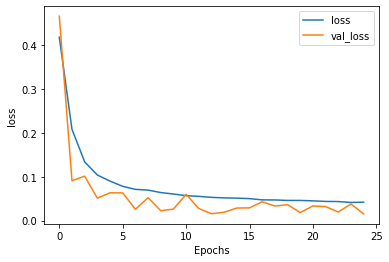

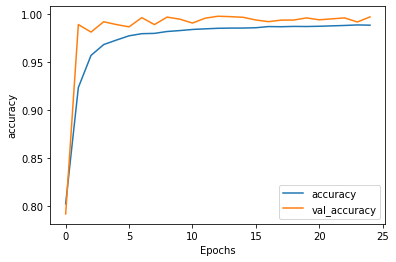

 17%|█▋        | 1/6 [07:30<37:33, 450.70s/it]

DISGUST
904/904 [==============================] - 7s 8ms/step - loss: 3.8636 - accuracy: 0.8257
Best threshold:  0.44
Optimal F1: 0.7913216296787015 at threshold: 0.44
Train Loss: 0.02909218519926071
Train Accuracy: 0.9935116767883301


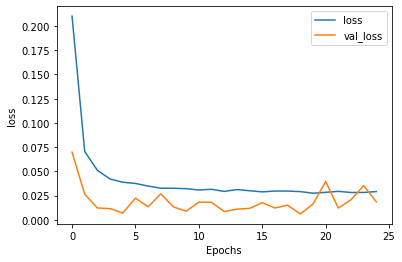

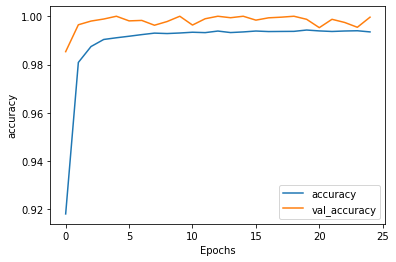

 33%|███▎      | 2/6 [15:01<30:02, 450.66s/it]

FEAR
865/865 [==============================] - 7s 8ms/step - loss: 4.6868 - accuracy: 0.6761
Best threshold:  0.1
Optimal F1: 0.642478813559322 at threshold: 0.1
Train Loss: 0.1269763708114624
Train Accuracy: 0.9579001665115356


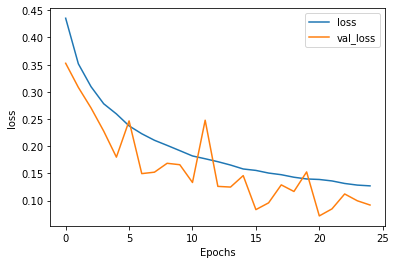

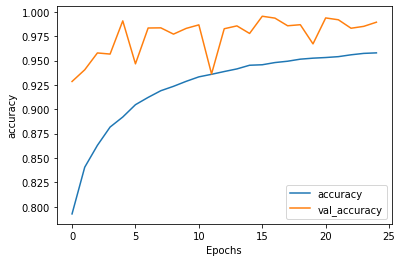

 50%|█████     | 3/6 [22:12<22:14, 444.94s/it]

JOY
777/777 [==============================] - 6s 8ms/step - loss: 1.3610 - accuracy: 0.7274
Best threshold:  0.1
Optimal F1: 0.7466635171843629 at threshold: 0.1
Train Loss: 0.27380943298339844
Train Accuracy: 0.8879334926605225


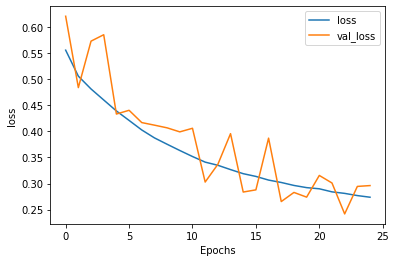

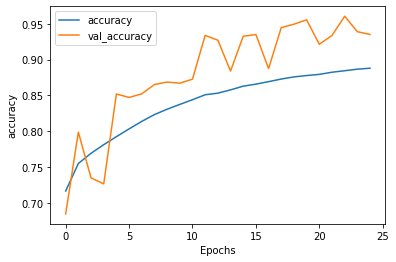

 67%|██████▋   | 4/6 [28:40<14:15, 427.79s/it]

SADNESS
880/880 [==============================] - 7s 8ms/step - loss: 6.5409 - accuracy: 0.6600
Best threshold:  0.11
Optimal F1: 0.5628623016250119 at threshold: 0.11
Train Loss: 0.08614739030599594
Train Accuracy: 0.9740318059921265


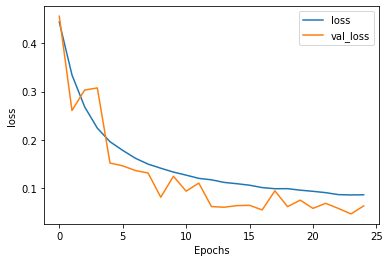

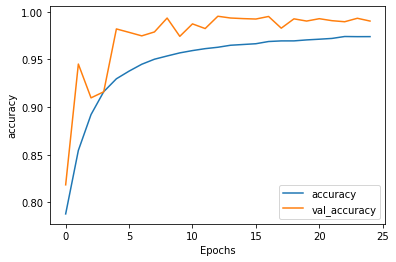

 83%|████████▎ | 5/6 [35:58<07:10, 430.80s/it]

SURPRISE
891/891 [==============================] - 7s 8ms/step - loss: 8.1424 - accuracy: 0.6513
Best threshold:  0.13
Optimal F1: 0.5184965673927001 at threshold: 0.13
Train Loss: 0.05623529106378555
Train Accuracy: 0.9829152226448059


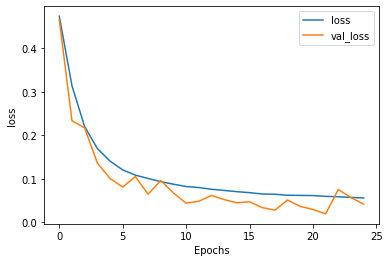

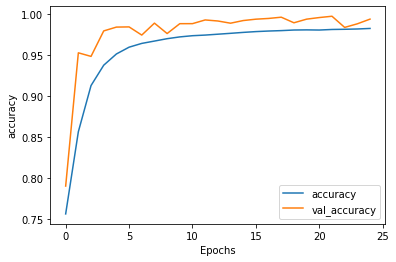

100%|██████████| 6/6 [43:22<00:00, 433.76s/it]


In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


def f1_smart(y_true, y_pred):
    thresholds = []
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        res = metrics.f1_score(y_true, (y_pred > thresh).astype(int))
        thresholds.append([thresh, res])
        printout = "F1 score at threshold {0} is {1}".format(thresh, res)
        # print(printout)
    thresholds.sort(key=lambda x: x[1], reverse=True)
    best_thresh = thresholds[0][0]
    best_f1 = thresholds[0][1]
    print("Best threshold: ", best_thresh)
    return best_f1, best_thresh


def train(sentiment):
    model = model_gru(w2v.wv.vectors, size_word2vec)
    print(sentiment.upper())
    x_train, y_train, x_test, y_test = getSentData(sentiment)
    hist = model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        epochs=25,
        batch_size=250,
        shuffle=True,  # ?
        verbose=0,
    )
    score = model.evaluate(x_test, y_test, verbose=1)
    y_pred_test = model.predict([x_test], batch_size=250, verbose=0)

    f1, threshold = f1_smart(y_test, y_pred_test)
    printout = "Optimal F1: {} at threshold: {}".format(f1, threshold)
    print(printout)
    print("Train Loss:", hist.history["loss"][-1])
    print("Train Accuracy:", hist.history["accuracy"][-1])

    plot_graphs(hist, "loss")
    plot_graphs(hist, "accuracy")

    return model


models = dict()
for s in tqdm(sentiments):
    models[s] = train(s)

In [ ]:
def getModelInput(phrase):
    x = cleanText(phrase)
    x = [getIndex(t) for t in x]
    x = pad_sequences([x], maxlen=MAX_SEQUENCE_LENGTH)
    return x


def getEmotions(phrase):
    # sentiments = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
    x = getModelInput(phrase)
    return [models[s].predict(x) for s in sentiments]

In [ ]:
model_json = model_gru(w2v.wv.vectors, size_word2vec).to_json()
with open("models/bi-gru" + str(size_word2vec) + ".json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
for s in sentiments:
    models[s].save_weights("models/" + s + "_weights.h5")

In [ ]:
models["anger"].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 300)      5564400     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 35, 70)       70770       embedding[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 70)           0           bidirectional[0][0]              
______________________________________________________________________________________________

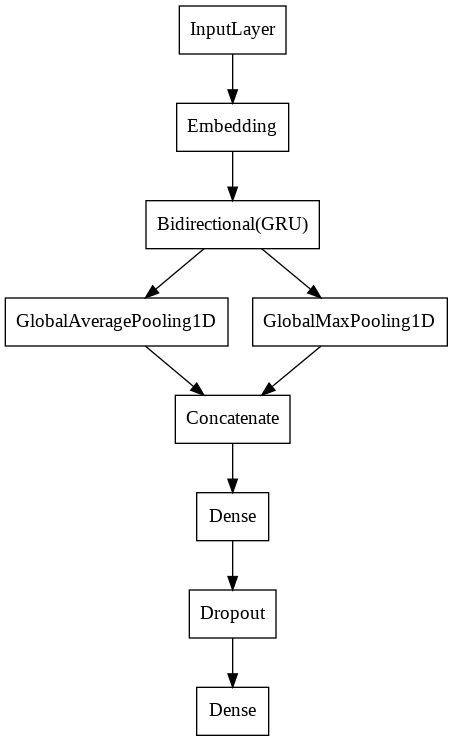

In [ ]:
tf.keras.utils.plot_model(
    models["anger"],
    to_file="figures/model.png",
    show_shapes=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Métricas

### Erro

Para saber se a rede neural está aprendendo ou não, você precisa comparar o valor da saída com o valor esperado. E como a gente computa essa diferença? Existem diferentes formas de se calcular o erro, depende da aplicação.

### Accurácia

Mostra o quão próximo o valor que a rede retorna está do valor que estamos esperando. É um valor no qual queremos maximizar, e quanto mais perto de 1, melhor é o resultado.

### F1 Score

O F1 Score é uma métrica que leva em consideração outras duas métricas que são precisão e revocação (recall). 
Esse método também ajuda a escolher o threshold necessário para classificar a saída como 0 ou 1, pois comparamos direfentes valores e o de melhor F1 score é o escolhido. Esse método é chamado F1 smart.

![f1scoer](https://wikimedia.org/api/rest_v1/media/math/render/svg/dd577aee2dd35c5b0e349327528a5ac606c7bbbf)


#### Precisão
A precisão pode ser interpretada como: dos que eu classifiquei como certos, quantos eram realmente certos?

![precision](https://miro.medium.com/proxy/1*YJgI2WpzsAlSRUYQpGGlOw.png)


#### Recall
O recall nos diz com que frequência o classificador está encontrando exemplos de uma classe. Se for realmente dessa classe, o quanto frequente você classifica como ela? Seria esta a pergunta a ser respondida.

![recall](https://miro.medium.com/proxy/1*KANwWvS_apYH-Pi7w2D24Q.png)



#### Links
https://medium.com/@vilsonrodrigues/machine-learning-o-que-s%C3%A3o-acurracy-precision-recall-e-f1-score-f16762f165b0

In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        5.0G        279M        261M        7.4G         10G
Swap:            0B          0B          0B


In [ ]:
!nvidia-smi

Tue Jun 23 17:05:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    62W / 149W |    494MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.3 LTS
Release:	18.04
Codename:	bionic
